In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/Users/dave/Library/CloudStorage/OneDrive-PolitecnicodiMilano/PhD/Repositories/partially-controllable-MDP


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import OrderedDict, defaultdict
import gymnasium as gym
import json
import matplotlib.ticker as ticker
from algo.utils import key_to_obs, build_state_index_map
from pcmdp.utils import parameter_generator

In [8]:
sns.set_theme()
sns.set_style('whitegrid')
sns.set_context("paper")
plot_colors = sns.color_palette('colorblind')
sns.set(font_scale=1.2)

alg_color = OrderedDict({
    #'random': plot_colors[5],
    #'longest_first': plot_colors[6],
    #'shortest_first': plot_colors[7],
    'ql': plot_colors[0],
    'exaq': plot_colors[1],
    'ucbvi': plot_colors[2],
    'exavi': plot_colors[3],
})

alg_markers = OrderedDict({
    'random': '.',
    'longest_first': 'o',
    'shortest_first': 's',
    'ql': 's',
    'exaq': 's',
})

alg_labels = {
    'random': 'Random',
    'longest_first': 'LF',
    'shortest_first': 'SF',
    'ql': 'Q-Learning',
    'exaq': 'ExAQ',
    'ucbvi': 'UCBVI',
    'exavi': 'ExAVI'
}

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def plot_seed_curves(results_dict, 
                     algo, 
                     title="Evaluation Over Different Seeds", 
                     figsize=(8, 5), 
                     tick_step=100, 
                     max_idx=-1):
    """
    Plot mean evaluation return per seed for the selected algorithm,
    with 95% confidence intervals.
    
    results_dict: dict
        {algorithm: {seed: {episode: [returns, ...]}}}
    """
    plt.figure(figsize=figsize)
    seeds_dict = results_dict[algo]
    colors = sns.color_palette('colorblind', len(seeds_dict.keys()))
    
    for i, seed in enumerate(seeds_dict.keys()):
        seed_curve = seeds_dict[seed]
        episodes = np.array(sorted([int(k) for k in seed_curve.keys()]))
        episedes = episodes[:max_idx]
        
        per_episode_mean = np.array([np.mean(seed_curve[str(e)]) for e in episodes])
        sem = stats.sem(per_episode_mean, axis=0)
        ci95 = 1.96 * sem  # 95% confidence interval
        
        plt.plot(episodes, per_episode_mean, label=seed, color=colors[i], linewidth=2)
        plt.fill_between(episodes, per_episode_mean - ci95, per_episode_mean + ci95, color=colors[i], alpha=0.2)

    plt.xlabel("Training Episode", fontsize=12)
    plt.ylabel("Evaluation Return (mean ± 95% CI)", fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(title="Algorithm")
    
    step = max(1, tick_step)
    plt.xticks(np.arange(0, episodes.max()+1, step))
    plt.xscale('log')
    
    plt.tight_layout()
    plt.show()

    
def plot_learning_curves(results_dict, 
                         title="Evaluation Performance", 
                         figsize=(8, 5), 
                         tick_step=100,
                         max_idx=-1):
    """
    Plot mean evaluation return per episode across seeds and algorithms,
    with 95% confidence intervals.
    
    results_dict: dict
        {algorithm: {seed: {episode: [returns, ...]}}}
    """
    plt.figure(figsize=figsize)
    
    for algo, seeds_dict in results_dict.items():
        # Collect per-seed mean reward per episode
        all_seeds_curves = []
        
        for seed, episodes_dict in seeds_dict.items():
            episodes = np.array(sorted([int(k) for k in episodes_dict.keys()]))
            episodes = episodes[:max_idx]
            
            # mean over test evaluations for this seed
            per_episode_mean = np.array([np.mean(episodes_dict[str(e)]) for e in episodes])
            all_seeds_curves.append(per_episode_mean)
        
        all_seeds_curves = np.array(all_seeds_curves)  # shape (n_seeds, n_episodes)
        mean_curve = np.mean(all_seeds_curves, axis=0)
        sem = stats.sem(all_seeds_curves, axis=0)
        ci95 = 1.96 * sem  # 95% confidence interval

        plt.plot(episodes, mean_curve, label=alg_labels[algo], color=alg_color[algo], linewidth=2)
        plt.fill_between(episodes, mean_curve - ci95, mean_curve + ci95, color=alg_color[algo], alpha=0.2)
    
    plt.xlabel("Training Episode", fontsize=12)
    plt.ylabel("Evaluation Return (mean ± 95% CI)", fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(title="Algorithm")
    
    step = max(1, tick_step)
    plt.xticks(np.arange(0, episodes.max()+1, step))
    plt.xscale('log')
    
    plt.tight_layout()
    plt.show()

    
def summarize_final_performance(results_dict):
    summary = {}
    for algo, seeds_dict in results_dict.items():
        final_rewards = []
        for seed, episodes_dict in seeds_dict.items():
            last_ep = max(episodes_dict.keys())
            final_rewards.append(np.mean(episodes_dict[last_ep]))
        summary[algo] = {
            "mean_final": np.mean(final_rewards),
            "std_final": np.std(final_rewards),
            "ci95": 1.96 * np.std(final_rewards) / np.sqrt(len(final_rewards))
        }
    return summary


In [10]:
import numpy as np
import matplotlib.pyplot as plt

def iqm(data, lower_q=25, upper_q=75):
    """Interquartile mean: mean of values between given percentiles."""
    flat = np.sort(np.concatenate(data))
    l, u = np.percentile(flat, [lower_q, upper_q])
    return flat[(flat >= l) & (flat <= u)].mean()

def bootstrap_iqm_ci(data, n_boot=1000, ci=95):
    """Bootstrap confidence interval for IQM."""
    rng = np.random.default_rng()
    iqms = []
    n_seeds = len(data)
    for _ in range(n_boot):
        resample = [data[i] for i in rng.integers(0, n_seeds, n_seeds)]
        iqms.append(iqm(resample))
    lower = np.percentile(iqms, (100 - ci) / 2)
    upper = np.percentile(iqms, 100 - (100 - ci) / 2)
    return np.mean(iqms), (lower, upper)

def plot_iqm_curves(results_dict, n_boot=1000, ci=95, figsize=(8,5)):
    """
    results_dict: {algorithm: {seed: {episode: [returns,...], ...}, ...}}
    Plots IQM cumulative reward per episode with bootstrap CIs.
    """
    plt.figure(figsize=figsize)

    for algo, seeds_dict in results_dict.items():
        episodes = next(iter(seeds_dict.values())).keys()
        iqm_means, iqm_lows, iqm_highs = [], [], []

        for ep in episodes:
            # gather all returns across seeds at this episode
            data = [seeds_dict[s][ep] for s in seeds_dict]
            m, (l, u) = bootstrap_iqm_ci(data, n_boot=n_boot, ci=ci)
            iqm_means.append(m)
            iqm_lows.append(l)
            iqm_highs.append(u)

        plt.plot(episodes, iqm_means, label=alg_labels[algo], color=alg_color[algo])
        plt.fill_between(episodes, iqm_lows, iqm_highs, alpha=0.2)

    plt.xlabel("Training Episode")
    plt.ylabel("Cumulative Reward (IQM ± CI)")
    plt.title("Learning Curves with Interquartile Mean and Bootstrap CIs")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [85]:
def plot_taxi_V_spatial(V, mode="mean"):
    """
    Visualize V[h, s] as a 5x5 grid for selected horizons, aggregated across passenger/destination states.
    V: np.ndarray of shape (H, 500)
    mode: how to aggregate over horizon ('mean', 'final', 'start')
    """
    env_settings = parameter_generator(world_file="pcmdp/taxi/world.yaml")
    env = gym.make("pcmdp/taxi-v0", settings=env_settings)
    
    keys, multipliers = build_state_index_map(env)
    
    H, S = V.shape
    grid_shape = (5, 5)
    n_passenger_locs = 5
    n_destinations = 4
    n_positions = 25  # 5x5 grid
    matrix = np.zeros((5,5))

    # Choose horizon slice or aggregate
    if mode == "mean":
        V_h = np.mean(V, axis=0)
    elif mode == "final":
        V_h = V[-1]
    elif mode == "start":
        V_h = V[0]
    else:
        raise ValueError("mode must be 'mean', 'final', or 'start'")

    # Aggregate by taxi position (averaging over passenger & destination states)
    spatial_V = np.zeros(n_positions)
    counts = np.zeros(n_positions)
    matrix_counts = np.zeros((5,5))
    for s in range(S):
        state = key_to_obs(s, env, keys, multipliers)
        taxi_row = state['row']
        taxi_col = state['col']
        idx = taxi_row * 5 + taxi_col
        spatial_V[idx] += V_h[s]
        matrix[taxi_row, taxi_col] += V_h[s]
        counts[idx] += 1
        matrix_counts[taxi_row, taxi_col] +=  1
    spatial_V /= np.maximum(counts, 1)
    matrix /= matrix_counts
    
    # Plot as heatmap
    plt.figure(figsize=(5, 5))
    im = plt.imshow(matrix, cmap="viridis", origin="upper")
    plt.colorbar(im, label="Value")
    plt.title(f"Aggregated Value Function ({mode}) across Passenger/Destination states")
    plt.xticks(range(5))
    plt.yticks(range(5))
    plt.grid(visible=None, alpha=0.3)
    plt.gca().invert_yaxis()
    plt.show()

    
def plot_taxi_Nsa_spatial(N_sa, mode="sum"):
    """
    Visualize state-action visitation for Taxi-v3.
    N_sa: np.ndarray of shape (500, 6)
    mode: 'sum' (aggregate over horizon) or 'final' (last step)
    """
    env_settings = parameter_generator(world_file="pcmdp/taxi/world.yaml")
    env = gym.make("pcmdp/taxi-v0", settings=env_settings)
    
    keys, multipliers = build_state_index_map(env)
    
    S, A = N_sa.shape
    grid_shape = (5, 5)
    n_positions = 25

    N = N_sa
    matrix = np.zeros((5,5))

    # Aggregate across passenger/destination for each (row, col)
    spatial_N = np.zeros((n_positions, A))
    counts = np.zeros(n_positions)
    matrix_counts = np.zeros((5,5))
    for s in range(S):
        state = key_to_obs(s, env, keys, multipliers)
        taxi_row = state['row']
        taxi_col = state['col']
        idx = taxi_row * 5 + taxi_col
        spatial_V[idx] += V_h[s]
        matrix[taxi_row, taxi_col] += V_h[s]
        counts[idx] += 1
        matrix_counts[taxi_row, taxi_col] += 1
    spatial_N /= np.maximum(counts[:, None], 1)
    matrix /= matrix_counts

    # Plot per-action heatmaps
    fig, axes = plt.subplots(1, A, figsize=(4*A, 4))
    actions = ["South", "North", "East", "West", "Pickup", "Dropoff"]
    for a in range(A):
        ax = axes[a]
        im = ax.imshow(np.log1p(matrix[:, a]),
                       cmap="magma", origin="upper")
        ax.set_title(f"Action: {actions[a]}")
        ax.set_xticks(range(5))
        ax.set_yticks(range(5))
        ax.invert_yaxis()
        fig.colorbar(im, ax=ax, shrink=0.7)
    plt.suptitle("Taxi-v3 State-Action Visit Counts (log scale)")
    plt.grid(False, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Model-based Algorithms

In [86]:
res = {}
res['ucbvi'] = {}
res['exavi'] = {}

for i in range(1, 11):
    with open(f'logs/results/taxi/10seeds/exa_vi/2025-11-08_17-11-07/{i}/learning_curve.json', 'r') as f:
        res['exavi'][i] = json.load(f)

    with open(f'logs/results/taxi/10seeds/ucbvi/2025-11-08_17-16-01/{i}/learning_curve.json', 'r') as f:
        res['ucbvi'][i] = json.load(f)

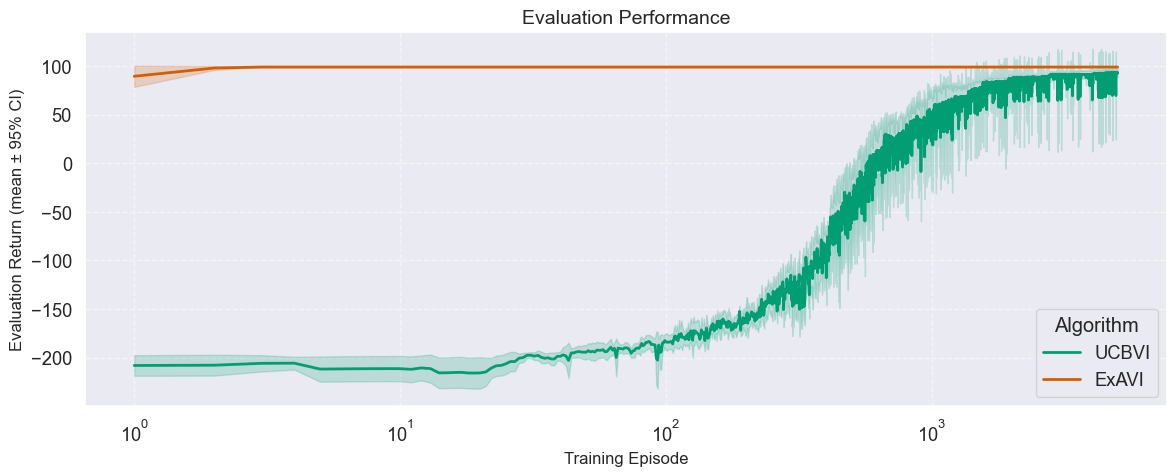

In [87]:
# TAXI Environment
plot_learning_curves(res, figsize=(12,5), tick_step=1000)

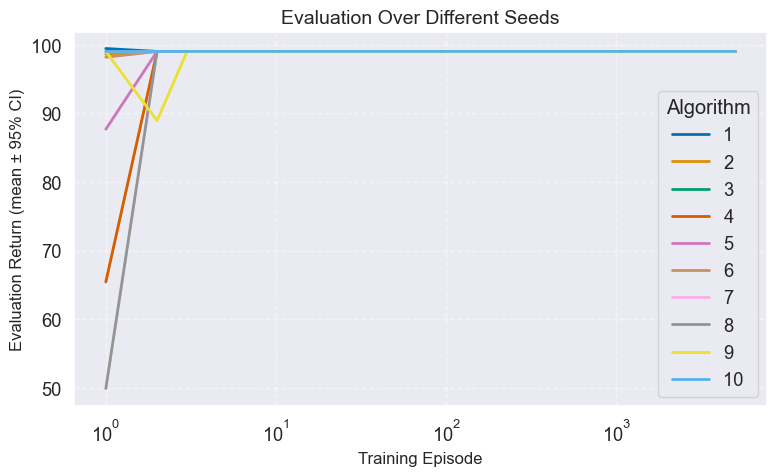

In [88]:
plot_seed_curves(res, algo='exavi', tick_step=1000)

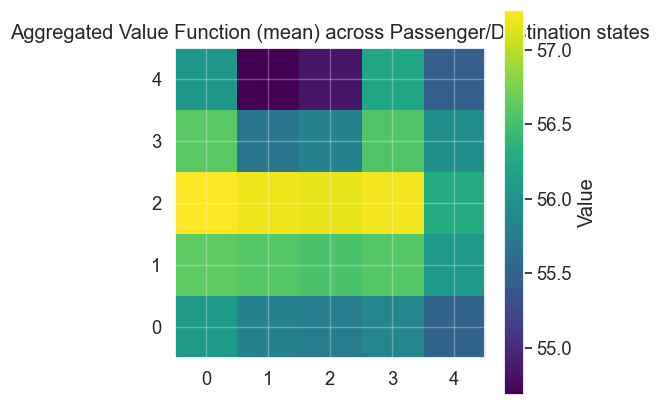

In [91]:
import pickle

with open("logs/results/taxi/10seeds/ucbvi/2025-11-08_17-16-01/6/world_models.pkl", "rb") as f:
    data = pickle.load(f)
    
V = data["V"]
N_sa = data["N_sa"]

plot_taxi_V_spatial(V)
#plot_taxi_Nsa_spatial(N_sa)

# Model-free Algorithms

In [193]:
res = {}
res['ql'] = {}
res['exaq'] = {}

for i in range(1, 11):
    with open(f'logs/results/taxi/10seeds/exa_ql/2025-11-08_18-09-36/{i}/learning_curve.json', 'r') as f:
        res['exaq'][i] = json.load(f)

    with open(f'logs/results/taxi/10seeds/ql/2025-11-08_17-10-00/{i}/learning_curve.json', 'r') as f:
        res['ql'][i] = json.load(f)

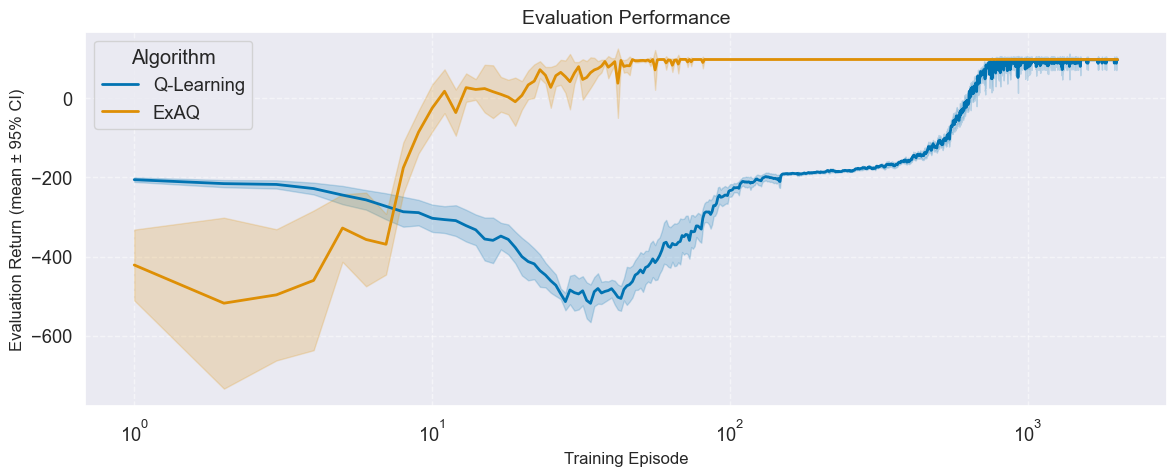

In [194]:
# TAXI Environment
plot_learning_curves(res, figsize=(12,5), tick_step=200)

In [195]:
# plot_seed_curves(res, algo='exaq', figsize=(12,5), tick_step=200)

In [196]:
#plot_iqm_curves(res, figsize=(12,5))

In [197]:
res = {}
res['ql'] = {}
res['exaq'] = {}

for i in range(1, 11):
    with open(f'logs/results/elevator/10seeds/exa_ql/2025-11-08_18-08-53/{i}/learning_curve.json', 'r') as f:
        res['exaq'][i] = json.load(f)

    with open(f'logs/results/elevator/10seeds/ql/2025-11-08_17-17-04/{i}/learning_curve.json', 'r') as f:
        res['ql'][i] = json.load(f)

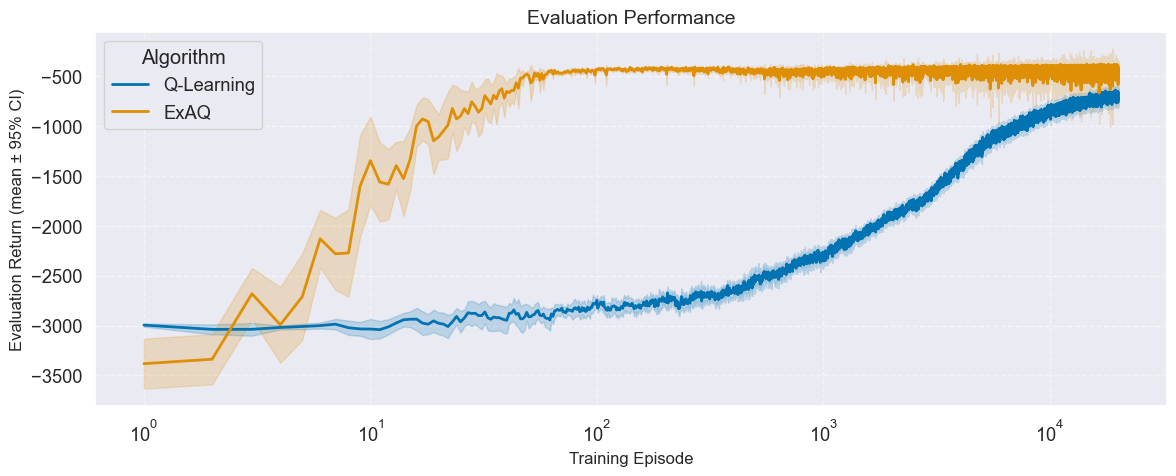

In [198]:
# ELEVATOR Environment
plot_learning_curves(res, figsize=(12,5), tick_step=2000, max_idx=20000)